# **Fingerprints Gender Classification**
## JCE - Final Project 
### By Kobi Amsellem & Zohar Kedem

#### Find a model that helps a forensic investigator decide if a fingerprint belonge to Female or Male
#### 2 classeses Classification (Female, Male)


Expirements:
1. decide of using transfer learning or full training 
2. Comparison between couple of backbones models 
3. Comparison optimizers
4. Comparison learning rates
5. Comparison loss function

* train best model for deployment

In [1]:
from datasets import SOCOFingGender
import FPMLmodule.backbones as backbones
import FPMLmodule.classifiers as classifiers
import FPMLmodule.utils as utils
from FPMLmodule.fpml import FPML 
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
import copy

import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


### **Hyperparameters and default settings**  ###

* define the global configuration for training
* define datset configuration as split, batch size etc.
* declare relevant backbones weights path
* set epochs for study and final model


In [2]:
# Global Config
seed=9
imgDim = (120, 120, 3)
imgHeight, imgWidth, imgChannels = imgDim
batchSize = 32

# Dataset configuration
dsConfig = {
    'batchSize': batchSize, 
    'parallelTune': tf.data.AUTOTUNE, 
    'split': [0.7, 0.15, 0.15], 
    'inputDim': imgDim, 
    'seed': seed, 
    'shuffle': True
    }

weightsRN50 = "./weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
weightsMNV2 = "./weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"
weightsENB2 = "./weights/efficientnetb2_notop.h5"
weightsINCEPTIONV3 = "./weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weightsXCEPTION = "./weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Training interval
epochsForSearch = 10
epochsForBest = 100

### **Create Dataset**

* labeld as Male/Female 
* sampling mode
* split to train/test/validation sub-datasets

In [3]:
SOCOGender = SOCOFingGender(**dict(dsConfig, sampling=SOCOFingGender.UNDER_SAMPLING))
genderDs = SOCOGender.create()
trainDs, testDs, valDs = genderDs

Metal device set to: AMD Radeon Pro 5500M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB



2022-05-08 03:33:38.149658: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-08 03:33:38.150315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-08 03:33:38.150574: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Show Datasets Split Sizes and split diversity ###

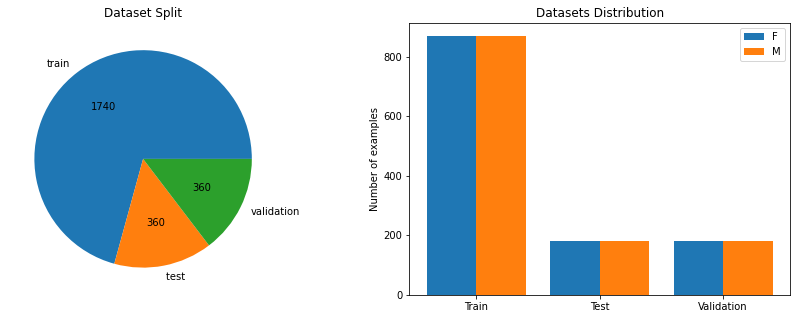

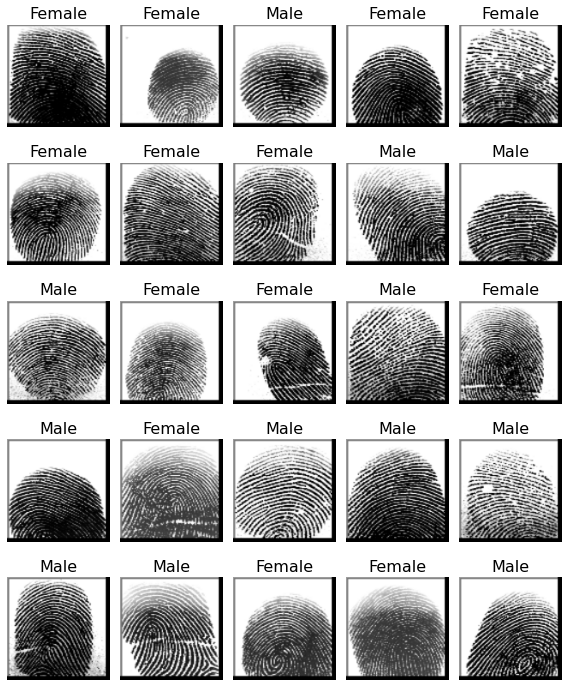

In [4]:
utils.displayDatasetSplitInformation(genderDs, SOCOGender.classNames)
utils.displayDsSamples(trainDs, shape=(5,5), classNames=['Female', 'Male'])

### Define base hyperparameters for study ###
* optimizer
* learning rate
* loss function
* accuracy metric

In [5]:
nbClasses = len(SOCOGender.classNames)
activation = "softmax"
hypers = {
    "optimizer": Adam,
    "learningRate": 0.001,
    "loss": 'binary_crossentropy',
    "metrics": 'accuracy'
}

### **Using MobileNetV2 to compare transfer learning options**

define 3 studies using mobilenet as backbone to compare between:
* transfer learning from imagenet and train the classifier only
* transfer learning from imagenet and train the whole model
* train the model from scratch

In [6]:


trainingModeStudy = {
    "mobilenetV2-pretrained-untrainable" : {
        "architecture": {
            "backbone": backbones.MobileNetV2(imgDim, weights=weightsMNV2, trainable=False),
            "classfier": classifiers.DefaultClassifier(nbClasses, activation),
            "inputLayer": None, 
            "inputDim": imgDim
        },
        "hyperparameters":hypers
    },
    "MobileNetV2-pretrained-trainable" : {
        "architecture": {
            "backbone": backbones.MobileNetV2(imgDim, weights=weightsMNV2, trainable=True),
            "classfier": classifiers.DefaultClassifier(nbClasses, activation),
            "inputLayer": None, 
            "inputDim": imgDim
        },
        "hyperparameters":hypers
    },
    "MobileNetV2-fulltraining" : {
        "architecture": {
            "backbone": backbones.MobileNetV2(imgDim, weights=None, trainable=True),
            "classfier": classifiers.DefaultClassifier(nbClasses, activation),
            "inputLayer": None, 
            "inputDim": imgDim
        },
        "hyperparameters":hypers
    }
}

trainingModeHistories = utils.researchStudies(trainDs, valDs, trainingModeStudy, epochsForSearch)


Epoch 1/10


2022-05-08 03:33:44.451950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 03:33:48.617579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 - 7s - loss: 0.8965 - accuracy: 0.5397 - val_loss: 0.6870 - val_accuracy: 0.5278 - 7s/epoch - 127ms/step
Epoch 2/10
55/55 - 2s - loss: 0.6962 - accuracy: 0.5724 - val_loss: 0.6692 - val_accuracy: 0.5611 - 2s/epoch - 40ms/step
Epoch 3/10
55/55 - 2s - loss: 0.6572 - accuracy: 0.6184 - val_loss: 0.6642 - val_accuracy: 0.5778 - 2s/epoch - 39ms/step
Epoch 4/10
55/55 - 2s - loss: 0.6459 - accuracy: 0.6385 - val_loss: 0.6766 - val_accuracy: 0.5917 - 2s/epoch - 39ms/step
Epoch 5/10
55/55 - 2s - loss: 0.6344 - accuracy: 0.6385 - val_loss: 0.6669 - val_accuracy: 0.5917 - 2s/epoch - 39ms/step
Epoch 6/10
55/55 - 2s - loss: 0.6354 - accuracy: 0.6471 - val_loss: 0.6789 - val_accuracy: 0.5833 - 2s/epoch - 39ms/step
Epoch 7/10
55/55 - 2s - loss: 0.6169 - accuracy: 0.6764 - val_loss: 0.6639 - val_accuracy: 0.5972 - 2s/epoch - 39ms/step
Epoch 8/10
55/55 - 2s - loss: 0.6153 - accuracy: 0.6598 - val_loss: 0.6565 - val_accuracy: 0.5917 - 2s/epoch - 40ms/step
Epoch 9/10
55/55 - 2s - loss: 0.6066 - acc

2022-05-08 03:34:13.294066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 03:34:23.655951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 - 14s - loss: 0.8661 - accuracy: 0.5546 - val_loss: 1.2381 - val_accuracy: 0.4917 - 14s/epoch - 258ms/step
Epoch 2/10
55/55 - 7s - loss: 0.6514 - accuracy: 0.6569 - val_loss: 0.7210 - val_accuracy: 0.5083 - 7s/epoch - 129ms/step
Epoch 3/10
55/55 - 7s - loss: 0.5879 - accuracy: 0.7115 - val_loss: 0.7333 - val_accuracy: 0.5444 - 7s/epoch - 125ms/step
Epoch 4/10
55/55 - 7s - loss: 0.5427 - accuracy: 0.7420 - val_loss: 0.7159 - val_accuracy: 0.5028 - 7s/epoch - 122ms/step
Epoch 5/10
55/55 - 7s - loss: 0.5551 - accuracy: 0.7351 - val_loss: 0.7354 - val_accuracy: 0.4861 - 7s/epoch - 123ms/step
Epoch 6/10
55/55 - 7s - loss: 0.4873 - accuracy: 0.7655 - val_loss: 0.7288 - val_accuracy: 0.5000 - 7s/epoch - 121ms/step
Epoch 7/10
55/55 - 7s - loss: 0.4312 - accuracy: 0.7977 - val_loss: 1.0047 - val_accuracy: 0.5000 - 7s/epoch - 120ms/step
Epoch 8/10
55/55 - 7s - loss: 0.3920 - accuracy: 0.8161 - val_loss: 0.8128 - val_accuracy: 0.5000 - 7s/epoch - 122ms/step
Epoch 9/10
55/55 - 7s - loss: 0.3

2022-05-08 03:35:29.482760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 03:35:39.534659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 - 14s - loss: 0.8737 - accuracy: 0.5178 - val_loss: 0.6932 - val_accuracy: 0.5000 - 14s/epoch - 249ms/step
Epoch 2/10
55/55 - 7s - loss: 0.6964 - accuracy: 0.5747 - val_loss: 0.6933 - val_accuracy: 0.5000 - 7s/epoch - 125ms/step
Epoch 3/10
55/55 - 7s - loss: 0.6343 - accuracy: 0.6379 - val_loss: 0.6935 - val_accuracy: 0.5000 - 7s/epoch - 122ms/step
Epoch 4/10
55/55 - 7s - loss: 0.6300 - accuracy: 0.6713 - val_loss: 0.6938 - val_accuracy: 0.5000 - 7s/epoch - 121ms/step
Epoch 5/10
55/55 - 7s - loss: 0.5746 - accuracy: 0.7063 - val_loss: 0.6935 - val_accuracy: 0.5000 - 7s/epoch - 119ms/step
Epoch 6/10
55/55 - 7s - loss: 0.5274 - accuracy: 0.7448 - val_loss: 0.6934 - val_accuracy: 0.5000 - 7s/epoch - 120ms/step
Epoch 7/10
55/55 - 7s - loss: 0.5013 - accuracy: 0.7724 - val_loss: 0.6955 - val_accuracy: 0.5000 - 7s/epoch - 121ms/step
Epoch 8/10
55/55 - 7s - loss: 0.4368 - accuracy: 0.8109 - val_loss: 0.6962 - val_accuracy: 0.5000 - 7s/epoch - 120ms/step
Epoch 9/10
55/55 - 7s - loss: 0.4

#### examine transfer learing mode results 

mobilenetV2-pretrained-untrainable


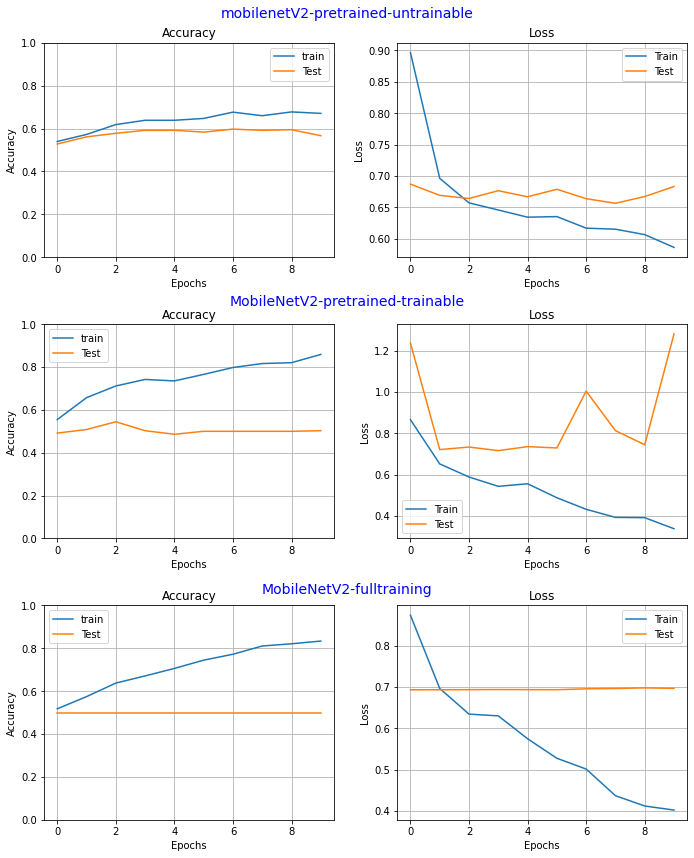

In [23]:
utils.displayStudiesProgress(trainingModeHistories)
trainingModeBestModel = utils.getBestStudyFromHistories(trainingModeHistories)
pretrained = 'pretrained' in trainingModeBestModel
trainable = 'untrainable' not in trainingModeBestModel
print(trainingModeBestModel)

### **Comparing Backbones**

define studies using different backbone to compare between:
* ResNet50
* EfficientNetB2
* InceptionV3
* Xception
* MobileNetV2


In [8]:
bestBackboneStudy = {
    "resnet50" : {
        "architecture": {
            "backbone": backbones.ResNet50(imgDim, weights=weightsRN50, trainable=trainable),
            "classfier": classifiers.DefaultClassifier(nbClasses, activation),
            "inputLayer":"", 
            "inputDim": imgDim
        },
        "hyperparameters": hypers
    },
    "efficientnet" : {
        "architecture": {
            "backbone": backbones.EfficientNetB2(imgDim, weights=weightsENB2, trainable=trainable),
            "classfier": classifiers.DefaultClassifier(nbClasses, activation),
            "inputLayer":"", 
            "inputDim": imgDim
        },
        "hyperparameters": hypers
    },
    "inceptionV3" : {
        "architecture": {
            "backbone": backbones.InceptionV3(imgDim, weights=weightsINCEPTIONV3, trainable=trainable),
            "classfier": classifiers.DefaultClassifier(nbClasses, activation),
            "inputLayer":"", 
            "inputDim": imgDim
        },
        "hyperparameters": hypers
    },
    "xception" : {
        "architecture": {
            "backbone": backbones.Xception(imgDim, weights=weightsXCEPTION, trainable=trainable),
            "classfier": classifiers.DefaultClassifier(nbClasses, activation),
            "inputLayer":"", 
            "inputDim": imgDim
        },
        "hyperparameters": hypers
    },
    
}

bestBackboneHistories = utils.researchStudies(trainDs, valDs, bestBackboneStudy, epochsForSearch)

Epoch 1/10


2022-05-08 03:36:44.902729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 03:36:50.653121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 - 10s - loss: 1.1285 - accuracy: 0.5328 - val_loss: 0.6873 - val_accuracy: 0.5861 - 10s/epoch - 177ms/step
Epoch 2/10
55/55 - 4s - loss: 0.7036 - accuracy: 0.5948 - val_loss: 0.6598 - val_accuracy: 0.6278 - 4s/epoch - 73ms/step
Epoch 3/10
55/55 - 4s - loss: 0.6448 - accuracy: 0.6483 - val_loss: 0.6535 - val_accuracy: 0.6500 - 4s/epoch - 73ms/step
Epoch 4/10
55/55 - 4s - loss: 0.6409 - accuracy: 0.6552 - val_loss: 0.6477 - val_accuracy: 0.6361 - 4s/epoch - 72ms/step
Epoch 5/10
55/55 - 4s - loss: 0.6271 - accuracy: 0.6667 - val_loss: 0.6601 - val_accuracy: 0.6222 - 4s/epoch - 72ms/step
Epoch 6/10
55/55 - 4s - loss: 0.5933 - accuracy: 0.6931 - val_loss: 0.6422 - val_accuracy: 0.6556 - 4s/epoch - 72ms/step
Epoch 7/10
55/55 - 4s - loss: 0.5906 - accuracy: 0.6891 - val_loss: 0.6301 - val_accuracy: 0.6750 - 4s/epoch - 71ms/step
Epoch 8/10
55/55 - 4s - loss: 0.5973 - accuracy: 0.6966 - val_loss: 0.6402 - val_accuracy: 0.6500 - 4s/epoch - 73ms/step
Epoch 9/10
55/55 - 4s - loss: 0.5665 - a

2022-05-08 03:37:36.736215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 03:37:46.530318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 - 19s - loss: 0.8974 - accuracy: 0.5305 - val_loss: 0.6880 - val_accuracy: 0.6083 - 19s/epoch - 348ms/step
Epoch 2/10
55/55 - 5s - loss: 0.7116 - accuracy: 0.5408 - val_loss: 0.6902 - val_accuracy: 0.5944 - 5s/epoch - 84ms/step
Epoch 3/10
55/55 - 5s - loss: 0.6970 - accuracy: 0.5379 - val_loss: 0.6848 - val_accuracy: 0.5056 - 5s/epoch - 86ms/step
Epoch 4/10
55/55 - 4s - loss: 0.6896 - accuracy: 0.5644 - val_loss: 0.6597 - val_accuracy: 0.6472 - 4s/epoch - 81ms/step
Epoch 5/10
55/55 - 5s - loss: 0.6777 - accuracy: 0.5805 - val_loss: 0.6728 - val_accuracy: 0.5500 - 5s/epoch - 85ms/step
Epoch 6/10
55/55 - 5s - loss: 0.6722 - accuracy: 0.5897 - val_loss: 0.6452 - val_accuracy: 0.6639 - 5s/epoch - 86ms/step
Epoch 7/10
55/55 - 4s - loss: 0.6573 - accuracy: 0.6236 - val_loss: 0.6405 - val_accuracy: 0.6778 - 4s/epoch - 82ms/step
Epoch 8/10
55/55 - 4s - loss: 0.6485 - accuracy: 0.6293 - val_loss: 0.6148 - val_accuracy: 0.6611 - 4s/epoch - 80ms/step
Epoch 9/10
55/55 - 5s - loss: 0.6630 - a

2022-05-08 03:38:37.616735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 03:38:44.350296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 - 12s - loss: 12.1817 - accuracy: 0.5178 - val_loss: 3.3644 - val_accuracy: 0.5028 - 12s/epoch - 223ms/step
Epoch 2/10
55/55 - 4s - loss: 3.0991 - accuracy: 0.5287 - val_loss: 0.7605 - val_accuracy: 0.4972 - 4s/epoch - 65ms/step
Epoch 3/10
55/55 - 3s - loss: 1.1639 - accuracy: 0.5080 - val_loss: 0.6927 - val_accuracy: 0.5000 - 3s/epoch - 57ms/step
Epoch 4/10
55/55 - 3s - loss: 0.8388 - accuracy: 0.5167 - val_loss: 0.6932 - val_accuracy: 0.5000 - 3s/epoch - 58ms/step
Epoch 5/10
55/55 - 3s - loss: 0.7316 - accuracy: 0.5270 - val_loss: 0.6932 - val_accuracy: 0.5000 - 3s/epoch - 61ms/step
Epoch 6/10
55/55 - 3s - loss: 0.7244 - accuracy: 0.5132 - val_loss: 0.6932 - val_accuracy: 0.5000 - 3s/epoch - 58ms/step
Epoch 7/10
55/55 - 3s - loss: 0.7110 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.5000 - 3s/epoch - 57ms/step
Epoch 8/10
55/55 - 3s - loss: 0.7010 - accuracy: 0.5155 - val_loss: 0.6932 - val_accuracy: 0.5000 - 3s/epoch - 57ms/step
Epoch 9/10
55/55 - 3s - loss: 0.6968 - 

2022-05-08 03:39:19.374208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 03:39:26.294611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 - 11s - loss: 3.1424 - accuracy: 0.5293 - val_loss: 0.6777 - val_accuracy: 0.6028 - 11s/epoch - 201ms/step
Epoch 2/10
55/55 - 6s - loss: 1.0434 - accuracy: 0.5759 - val_loss: 0.6906 - val_accuracy: 0.5222 - 6s/epoch - 100ms/step
Epoch 3/10
55/55 - 5s - loss: 0.7500 - accuracy: 0.5580 - val_loss: 0.6903 - val_accuracy: 0.5972 - 5s/epoch - 100ms/step
Epoch 4/10
55/55 - 5s - loss: 0.7027 - accuracy: 0.5655 - val_loss: 0.6913 - val_accuracy: 0.5194 - 5s/epoch - 99ms/step
Epoch 5/10
55/55 - 5s - loss: 0.6833 - accuracy: 0.5856 - val_loss: 0.6798 - val_accuracy: 0.6028 - 5s/epoch - 99ms/step
Epoch 6/10
55/55 - 6s - loss: 0.6789 - accuracy: 0.5983 - val_loss: 0.6848 - val_accuracy: 0.5667 - 6s/epoch - 101ms/step
Epoch 7/10
55/55 - 5s - loss: 0.6892 - accuracy: 0.5805 - val_loss: 0.6857 - val_accuracy: 0.5389 - 5s/epoch - 98ms/step
Epoch 8/10
55/55 - 5s - loss: 0.6896 - accuracy: 0.5879 - val_loss: 0.6755 - val_accuracy: 0.6000 - 5s/epoch - 99ms/step
Epoch 9/10
55/55 - 5s - loss: 0.6653 

#### examine backbone study results 

efficient-net


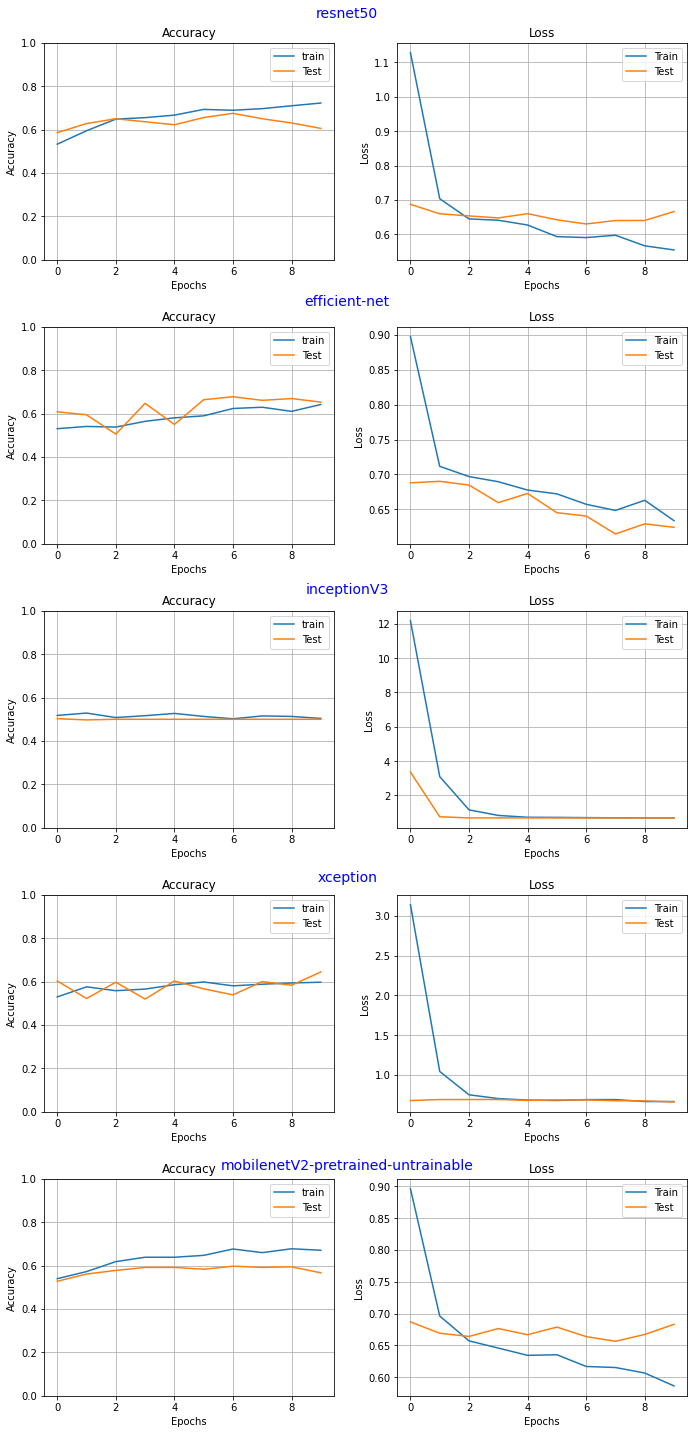

In [9]:
bestBackboneHistories[trainingModeBestModel] = trainingModeHistories[trainingModeBestModel]
bestBackboneStudy[trainingModeBestModel] = trainingModeStudy[trainingModeBestModel]
utils.displayStudiesProgress(bestBackboneHistories)
bestBackbone = utils.getBestStudyFromHistories(bestBackboneHistories)
print(bestBackbone)

### **Comparing Optimizers**

define studies using different optimizers to compare between:
* Nadam
* RMSprop
* Adam


In [10]:
optimizers = {
    'Nadam': Nadam,
    'RMSprop': RMSprop
    }

optimizersStudy = dict()

for opt in optimizers:
    studyName = bestBackbone+"_"+opt
    optimizersStudy[studyName] = copy.deepcopy(bestBackboneStudy[bestBackbone])
    optimizersStudy[studyName]["hyperparameters"]["optimizer"] = optimizers[opt]

optimizersHistories = utils.researchStudies(trainDs, valDs, optimizersStudy, epochsForSearch)

Epoch 1/10


2022-05-08 03:40:28.106314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 03:40:40.996479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 - 24s - loss: 0.8513 - accuracy: 0.5420 - val_loss: 0.6747 - val_accuracy: 0.5972 - 24s/epoch - 445ms/step
Epoch 2/10
55/55 - 6s - loss: 0.7151 - accuracy: 0.5414 - val_loss: 0.6721 - val_accuracy: 0.5667 - 6s/epoch - 101ms/step
Epoch 3/10
55/55 - 6s - loss: 0.6919 - accuracy: 0.5649 - val_loss: 0.6520 - val_accuracy: 0.6056 - 6s/epoch - 100ms/step
Epoch 4/10
55/55 - 6s - loss: 0.6802 - accuracy: 0.5937 - val_loss: 0.6515 - val_accuracy: 0.5833 - 6s/epoch - 102ms/step
Epoch 5/10
55/55 - 6s - loss: 0.6583 - accuracy: 0.6115 - val_loss: 0.6515 - val_accuracy: 0.6639 - 6s/epoch - 104ms/step
Epoch 6/10
55/55 - 5s - loss: 0.6544 - accuracy: 0.6241 - val_loss: 0.6487 - val_accuracy: 0.6500 - 5s/epoch - 97ms/step
Epoch 7/10
55/55 - 5s - loss: 0.6522 - accuracy: 0.6414 - val_loss: 0.6921 - val_accuracy: 0.5417 - 5s/epoch - 97ms/step
Epoch 8/10
55/55 - 5s - loss: 0.6380 - accuracy: 0.6466 - val_loss: 0.6200 - val_accuracy: 0.6417 - 5s/epoch - 92ms/step
Epoch 9/10
55/55 - 5s - loss: 0.6099

2022-05-08 03:41:43.565238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 03:41:56.018902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 - 23s - loss: 1.0155 - accuracy: 0.5253 - val_loss: 0.6870 - val_accuracy: 0.5667 - 23s/epoch - 421ms/step
Epoch 2/10
55/55 - 5s - loss: 0.7296 - accuracy: 0.5264 - val_loss: 0.7104 - val_accuracy: 0.5000 - 5s/epoch - 95ms/step
Epoch 3/10
55/55 - 5s - loss: 0.7144 - accuracy: 0.5454 - val_loss: 0.6813 - val_accuracy: 0.5806 - 5s/epoch - 88ms/step
Epoch 4/10
55/55 - 5s - loss: 0.7009 - accuracy: 0.5667 - val_loss: 0.6800 - val_accuracy: 0.5389 - 5s/epoch - 89ms/step
Epoch 5/10
55/55 - 5s - loss: 0.6898 - accuracy: 0.5787 - val_loss: 0.6528 - val_accuracy: 0.6528 - 5s/epoch - 85ms/step
Epoch 6/10
55/55 - 5s - loss: 0.6802 - accuracy: 0.5810 - val_loss: 0.6851 - val_accuracy: 0.5278 - 5s/epoch - 86ms/step
Epoch 7/10
55/55 - 5s - loss: 0.6657 - accuracy: 0.6213 - val_loss: 0.6455 - val_accuracy: 0.6417 - 5s/epoch - 84ms/step
Epoch 8/10
55/55 - 5s - loss: 0.6612 - accuracy: 0.6218 - val_loss: 0.6360 - val_accuracy: 0.6722 - 5s/epoch - 84ms/step
Epoch 9/10
55/55 - 4s - loss: 0.6481 - a

efficient-net_RMSprop


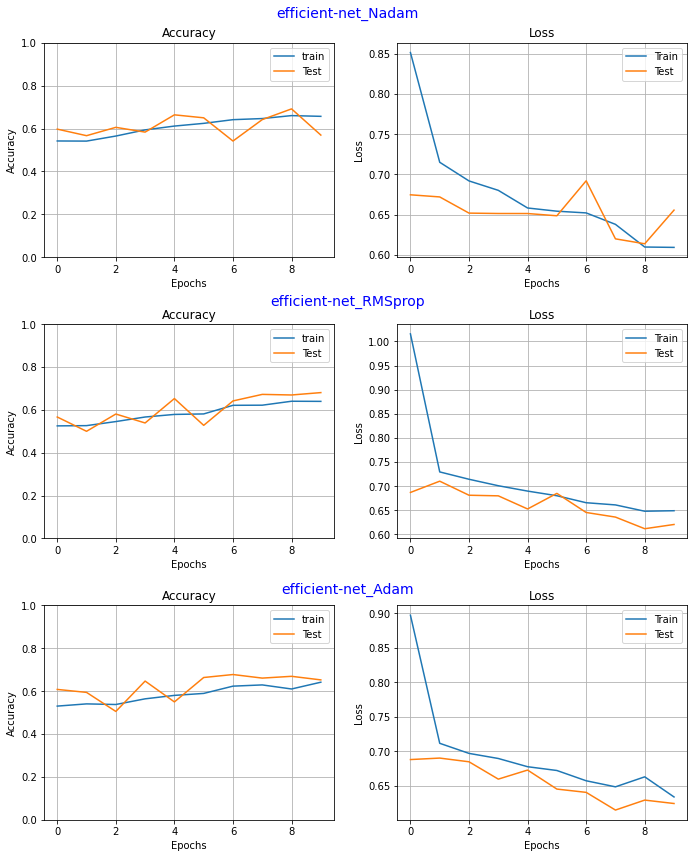

In [11]:
optimizersHistories[bestBackbone+"_Adam"] = bestBackboneHistories[bestBackbone]
optimizersStudy[bestBackbone+"_Adam"] = bestBackboneStudy[bestBackbone]
utils.displayStudiesProgress(optimizersHistories)
bestOptimizier = utils.getBestStudyFromHistories(optimizersHistories)
print(bestOptimizier)

### **Comparing Learning rates**

define studies using different lr to compare between:
* 0.1
* 0.01
* 0.001
* 0.0001
* 0.00001


In [12]:
learningRates = [0.1, 0.1e-1, 0.1e-3, 0.1e-4]

learningRatesStudy = dict()

for lr in learningRates:
    studyName = bestOptimizier+"_"+str(lr)
    learningRatesStudy[studyName] = copy.deepcopy(optimizersStudy[bestOptimizier])
    learningRatesStudy[studyName]["hyperparameters"]["learningRate"] = lr

    
learningRatesHistories = utils.researchStudies(trainDs, valDs, learningRatesStudy, epochsForSearch)

Epoch 1/10


2022-05-08 03:42:53.244228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 03:43:06.650116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 - 24s - loss: 6536.0576 - accuracy: 0.5276 - val_loss: 2.1726 - val_accuracy: 0.4972 - 24s/epoch - 439ms/step
Epoch 2/10
55/55 - 5s - loss: 1.9574 - accuracy: 0.4902 - val_loss: 0.6952 - val_accuracy: 0.5000 - 5s/epoch - 91ms/step
Epoch 3/10
55/55 - 5s - loss: 26.6200 - accuracy: 0.4920 - val_loss: 0.6966 - val_accuracy: 0.5000 - 5s/epoch - 89ms/step
Epoch 4/10
55/55 - 5s - loss: 0.6960 - accuracy: 0.4902 - val_loss: 0.6961 - val_accuracy: 0.5000 - 5s/epoch - 88ms/step
Epoch 5/10
55/55 - 5s - loss: 0.6956 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5000 - 5s/epoch - 83ms/step
Epoch 6/10
55/55 - 5s - loss: 8.0027 - accuracy: 0.5029 - val_loss: 0.6973 - val_accuracy: 0.5000 - 5s/epoch - 83ms/step
Epoch 7/10
55/55 - 5s - loss: 0.6952 - accuracy: 0.5069 - val_loss: 0.6952 - val_accuracy: 0.5000 - 5s/epoch - 87ms/step
Epoch 8/10
55/55 - 5s - loss: 0.6957 - accuracy: 0.5046 - val_loss: 0.7002 - val_accuracy: 0.5000 - 5s/epoch - 84ms/step
Epoch 9/10
55/55 - 5s - loss: 0.6958

2022-05-08 03:44:04.245967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 03:44:19.043190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 - 29s - loss: 11.7795 - accuracy: 0.5057 - val_loss: 0.8050 - val_accuracy: 0.5000 - 29s/epoch - 530ms/step
Epoch 2/10
55/55 - 5s - loss: 0.7726 - accuracy: 0.5011 - val_loss: 0.6933 - val_accuracy: 0.5000 - 5s/epoch - 99ms/step
Epoch 3/10
55/55 - 5s - loss: 0.6935 - accuracy: 0.4828 - val_loss: 0.6932 - val_accuracy: 0.5000 - 5s/epoch - 96ms/step
Epoch 4/10
55/55 - 6s - loss: 0.6935 - accuracy: 0.4954 - val_loss: 0.6932 - val_accuracy: 0.5000 - 6s/epoch - 102ms/step
Epoch 5/10
55/55 - 6s - loss: 0.6936 - accuracy: 0.4908 - val_loss: 0.6931 - val_accuracy: 0.5000 - 6s/epoch - 110ms/step
Epoch 6/10
55/55 - 5s - loss: 0.6936 - accuracy: 0.4862 - val_loss: 0.6931 - val_accuracy: 0.5000 - 5s/epoch - 98ms/step
Epoch 7/10
55/55 - 5s - loss: 0.6936 - accuracy: 0.4805 - val_loss: 0.6931 - val_accuracy: 0.5000 - 5s/epoch - 95ms/step
Epoch 8/10
55/55 - 5s - loss: 0.6934 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5000 - 5s/epoch - 90ms/step
Epoch 9/10
55/55 - 5s - loss: 0.7544 

2022-05-08 03:45:22.846789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 03:45:38.558949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 - 29s - loss: 0.8712 - accuracy: 0.5126 - val_loss: 0.6721 - val_accuracy: 0.6194 - 29s/epoch - 519ms/step
Epoch 2/10
55/55 - 5s - loss: 0.7370 - accuracy: 0.5695 - val_loss: 0.6342 - val_accuracy: 0.6944 - 5s/epoch - 90ms/step
Epoch 3/10
55/55 - 5s - loss: 0.7360 - accuracy: 0.5678 - val_loss: 0.6645 - val_accuracy: 0.6028 - 5s/epoch - 95ms/step
Epoch 4/10
55/55 - 5s - loss: 0.6918 - accuracy: 0.6086 - val_loss: 0.6507 - val_accuracy: 0.6417 - 5s/epoch - 96ms/step
Epoch 5/10
55/55 - 5s - loss: 0.6873 - accuracy: 0.5925 - val_loss: 0.6494 - val_accuracy: 0.6194 - 5s/epoch - 93ms/step
Epoch 6/10
55/55 - 5s - loss: 0.6598 - accuracy: 0.6253 - val_loss: 0.6264 - val_accuracy: 0.6750 - 5s/epoch - 94ms/step
Epoch 7/10
55/55 - 5s - loss: 0.6662 - accuracy: 0.6270 - val_loss: 0.6673 - val_accuracy: 0.5722 - 5s/epoch - 89ms/step
Epoch 8/10
55/55 - 5s - loss: 0.6706 - accuracy: 0.6184 - val_loss: 0.6336 - val_accuracy: 0.6778 - 5s/epoch - 91ms/step
Epoch 9/10
55/55 - 5s - loss: 0.6542 - a

2022-05-08 03:46:40.780513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 03:46:56.598360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 - 30s - loss: 1.1020 - accuracy: 0.4874 - val_loss: 0.7034 - val_accuracy: 0.5694 - 30s/epoch - 554ms/step
Epoch 2/10
55/55 - 5s - loss: 0.9354 - accuracy: 0.4828 - val_loss: 0.6758 - val_accuracy: 0.5861 - 5s/epoch - 100ms/step
Epoch 3/10
55/55 - 5s - loss: 0.8280 - accuracy: 0.5259 - val_loss: 0.6656 - val_accuracy: 0.6167 - 5s/epoch - 99ms/step
Epoch 4/10
55/55 - 5s - loss: 0.8070 - accuracy: 0.5213 - val_loss: 0.6560 - val_accuracy: 0.6139 - 5s/epoch - 89ms/step
Epoch 5/10
55/55 - 5s - loss: 0.7680 - accuracy: 0.5333 - val_loss: 0.6481 - val_accuracy: 0.6361 - 5s/epoch - 85ms/step
Epoch 6/10
55/55 - 5s - loss: 0.7648 - accuracy: 0.5379 - val_loss: 0.6462 - val_accuracy: 0.6361 - 5s/epoch - 85ms/step
Epoch 7/10
55/55 - 5s - loss: 0.7403 - accuracy: 0.5672 - val_loss: 0.6436 - val_accuracy: 0.6389 - 5s/epoch - 100ms/step
Epoch 8/10
55/55 - 5s - loss: 0.7522 - accuracy: 0.5580 - val_loss: 0.6404 - val_accuracy: 0.6389 - 5s/epoch - 92ms/step
Epoch 9/10
55/55 - 5s - loss: 0.7083 -

efficient-net_RMSprop_0.001


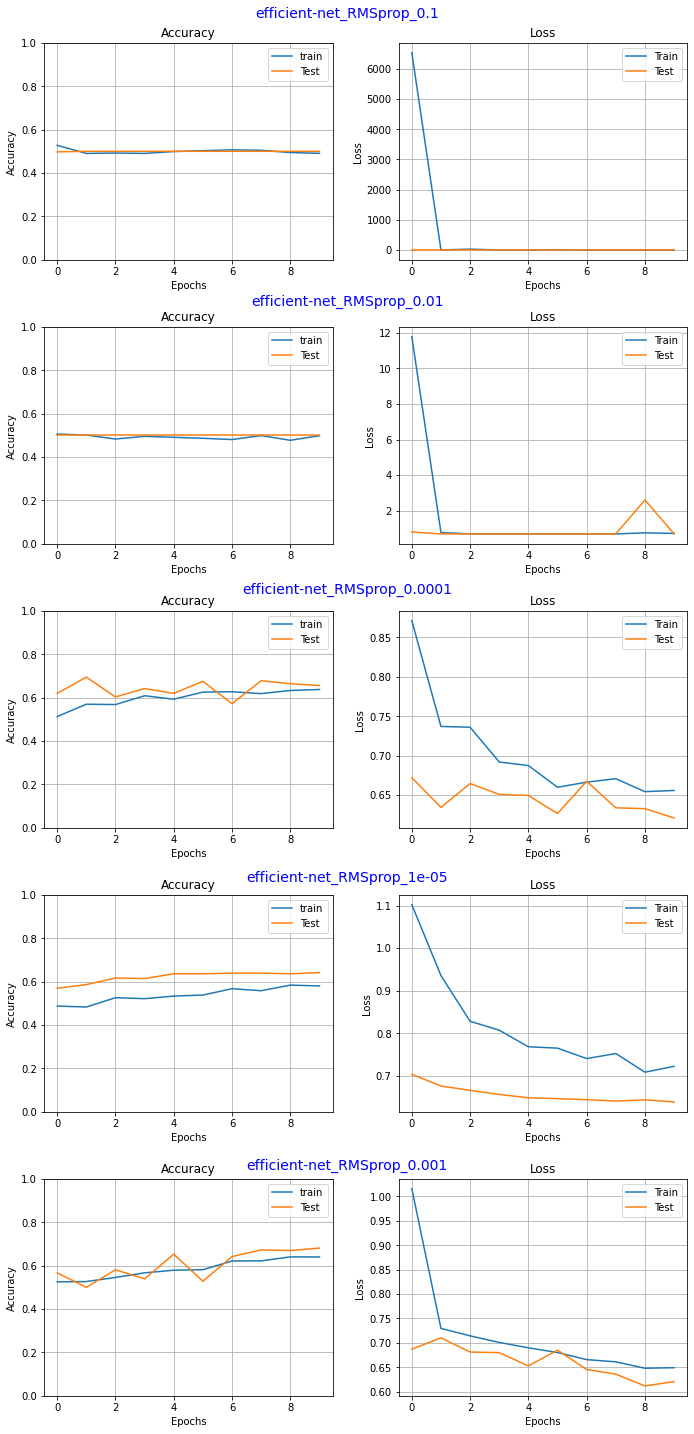

In [13]:
learningRatesHistories[bestOptimizier+"_"+str(hypers["learningRate"])] = optimizersHistories[bestOptimizier]
learningRatesStudy[bestOptimizier+"_"+str(hypers["learningRate"])] = optimizersStudy[bestOptimizier]
utils.displayStudiesProgress(learningRatesHistories)
bestLearningRate = utils.getBestStudyFromHistories(learningRatesHistories)
print(bestLearningRate)

### **Comparing Loss Functions**

define studies using different loss function to compare between:
* binary-focal-crossentropy
* hinge
* binary-crossentropy


In [14]:
losses = ['binary_focal_crossentropy', 'hinge']

lossStudy = dict()
for ls in losses:
    studyName = bestLearningRate+"_"+str(ls)
    lossStudy[studyName] = copy.deepcopy(learningRatesStudy[bestLearningRate])
    lossStudy[studyName]["hyperparameters"]["loss"] = ls

lossesHistories = utils.researchStudies(trainDs, valDs, lossStudy, epochsForSearch)

Epoch 1/10


2022-05-08 03:48:01.024657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 03:48:25.423536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 - 44s - loss: 0.7068 - accuracy: 0.4879 - val_loss: 0.1814 - val_accuracy: 0.5028 - 44s/epoch - 803ms/step
Epoch 2/10
55/55 - 6s - loss: 0.2064 - accuracy: 0.5431 - val_loss: 0.1745 - val_accuracy: 0.5000 - 6s/epoch - 101ms/step
Epoch 3/10
55/55 - 6s - loss: 0.1912 - accuracy: 0.5218 - val_loss: 0.1731 - val_accuracy: 0.5194 - 6s/epoch - 106ms/step
Epoch 4/10
55/55 - 6s - loss: 0.1805 - accuracy: 0.5236 - val_loss: 0.1733 - val_accuracy: 0.5000 - 6s/epoch - 113ms/step
Epoch 5/10
55/55 - 5s - loss: 0.1796 - accuracy: 0.5333 - val_loss: 0.1740 - val_accuracy: 0.5056 - 5s/epoch - 89ms/step
Epoch 6/10
55/55 - 5s - loss: 0.1770 - accuracy: 0.5569 - val_loss: 0.1674 - val_accuracy: 0.5722 - 5s/epoch - 93ms/step
Epoch 7/10
55/55 - 6s - loss: 0.1747 - accuracy: 0.5678 - val_loss: 0.1647 - val_accuracy: 0.5972 - 6s/epoch - 102ms/step
Epoch 8/10
55/55 - 6s - loss: 0.1719 - accuracy: 0.5684 - val_loss: 0.1678 - val_accuracy: 0.6333 - 6s/epoch - 102ms/step
Epoch 9/10
55/55 - 6s - loss: 0.171

2022-05-08 03:49:40.408890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 03:50:09.916534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 - 50s - loss: 1.0017 - accuracy: 0.4983 - val_loss: 1.0000 - val_accuracy: 0.5000 - 50s/epoch - 905ms/step
Epoch 2/10
55/55 - 6s - loss: 1.0012 - accuracy: 0.4989 - val_loss: 1.0000 - val_accuracy: 0.5000 - 6s/epoch - 118ms/step
Epoch 3/10
55/55 - 5s - loss: 0.9977 - accuracy: 0.5023 - val_loss: 1.0000 - val_accuracy: 0.5000 - 5s/epoch - 93ms/step
Epoch 4/10
55/55 - 5s - loss: 0.9960 - accuracy: 0.5040 - val_loss: 1.0000 - val_accuracy: 0.5000 - 5s/epoch - 93ms/step
Epoch 5/10
55/55 - 6s - loss: 1.0000 - accuracy: 0.5000 - val_loss: 1.0000 - val_accuracy: 0.5000 - 6s/epoch - 101ms/step
Epoch 6/10
55/55 - 5s - loss: 1.0000 - accuracy: 0.5000 - val_loss: 1.0000 - val_accuracy: 0.5000 - 5s/epoch - 92ms/step
Epoch 7/10
55/55 - 5s - loss: 1.0000 - accuracy: 0.5000 - val_loss: 1.0000 - val_accuracy: 0.5000 - 5s/epoch - 89ms/step
Epoch 8/10
55/55 - 5s - loss: 1.0000 - accuracy: 0.5000 - val_loss: 1.0000 - val_accuracy: 0.5000 - 5s/epoch - 85ms/step
Epoch 9/10
55/55 - 6s - loss: 1.0000 -

efficient-net_RMSprop_0.001_binary_focal_crossentropy


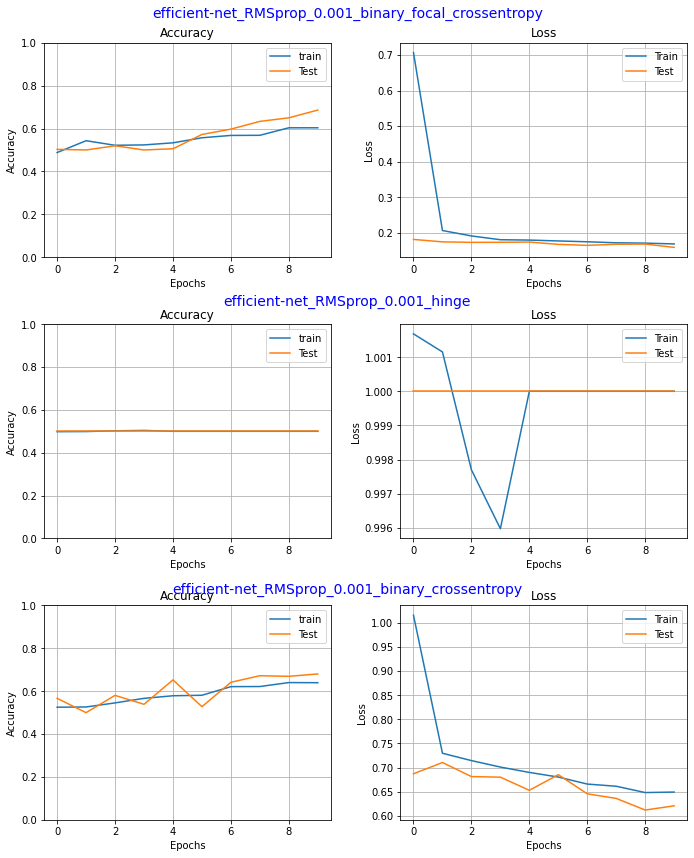

In [15]:
lossesHistories[bestLearningRate+"_"+str(hypers["loss"])] = learningRatesHistories[bestLearningRate]
lossStudy[bestLearningRate+"_"+str(hypers["loss"])] = learningRatesStudy[bestLearningRate]
utils.displayStudiesProgress(lossesHistories)
bestLoss = utils.getBestStudyFromHistories(lossesHistories)
print(bestLoss)

In [16]:
bestModelName = bestLoss
bestModelSetting = lossStudy[bestLoss]


In [17]:
trainValDs = trainDs.concatenate(valDs)
bestModel = FPML(**bestModelSetting["architecture"]).create(**bestModelSetting["hyperparameters"])
bestModelHistory = bestModel.fit(trainValDs, validation_data=testDs, epochs=epochsForBest, verbose=1)

Epoch 1/100


2022-05-08 03:51:24.693677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 0.5642 - accuracy: 0.5133

2022-05-08 03:51:59.243469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 53s 490ms/step - loss: 0.5642 - accuracy: 0.5133 - val_loss: 0.1786 - val_accuracy: 0.4944
Epoch 2/100
67/67 [==============================] - 7s 111ms/step - loss: 0.1950 - accuracy: 0.5076 - val_loss: 0.1733 - val_accuracy: 0.5000
Epoch 3/100
67/67 [==============================] - 7s 107ms/step - loss: 0.1869 - accuracy: 0.5205 - val_loss: 0.1728 - val_accuracy: 0.5000
Epoch 4/100
67/67 [==============================] - 6s 96ms/step - loss: 0.1788 - accuracy: 0.5324 - val_loss: 0.1695 - val_accuracy: 0.6139
Epoch 5/100
67/67 [==============================] - 6s 92ms/step - loss: 0.1771 - accuracy: 0.5338 - val_loss: 0.1698 - val_accuracy: 0.5861
Epoch 6/100
67/67 [==============================] - 6s 97ms/step - loss: 0.1770 - accuracy: 0.5490 - val_loss: 0.1658 - val_accuracy: 0.6306
Epoch 7/100
67/67 [==============================] - 7s 98ms/step - loss: 0.1723 - accuracy: 0.5548 - val_loss: 0.1662 - val_accuracy: 0.6000
Epoch 8/100
67

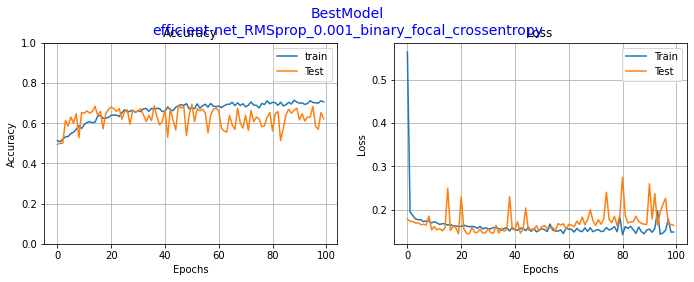

In [18]:
utils.displayStudiesProgress({"BestModel\n"+bestModelName : bestModelHistory})

2022-05-08 04:03:35.318014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 04:03:47.215162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.6222222222222222

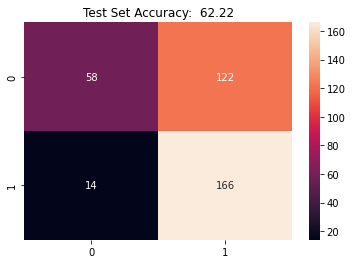

In [19]:
utils.displayConfusion(testDs, bestModel)

In [20]:
bestModel.save('./weights/'+bestModelName+'_SOCOGender.h5')